## 1.1 Check GPU

In [1]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla V100-SXM2-16GB, 460.32.03, 16160 MiB


## 1.2 Connect to google drive

In [2]:
# Connect Google drive
from google.colab import drive
import json
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


## 1.3 Import library and define global variable

### 1.3.1 Regular Library

In [3]:
import sys
import numpy as np
import pandas as pd
import os
import time
import string
import torch
import torchvision 
import torchsummary
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import *
from torch.utils import data
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from termcolor import cprint
from matplotlib.ticker import MaxNLocator

# Seed
np.random.seed(100)
torch.manual_seed(100)

# Global variable
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
sys.version
print(cuda, sys.version)

True 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]


### 1.3.2 Intall ctcdecode

In [4]:
!git clone --recursive https://github.com/parlance/ctcdecode.git
!pip install wget
%cd ctcdecode
!pip install .
%cd ..

Cloning into 'ctcdecode'...
remote: Enumerating objects: 1063, done.
remote: Total 1063 (delta 0), reused 0 (delta 0), pack-reused 1063
Receiving objects: 100% (1063/1063), 759.71 KiB | 4.69 MiB/s, done.
Resolving deltas: 100% (513/513), done.
Submodule 'third_party/ThreadPool' (https://github.com/progschj/ThreadPool.git) registered for path 'third_party/ThreadPool'
Submodule 'third_party/kenlm' (https://github.com/kpu/kenlm.git) registered for path 'third_party/kenlm'
Cloning into '/content/ctcdecode/third_party/ThreadPool'...
remote: Enumerating objects: 82, done.        
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82        
Cloning into '/content/ctcdecode/third_party/kenlm'...
remote: Enumerating objects: 13687, done.        
remote: Total 13687 (delta 0), reused 0 (delta 0), pack-reused 13687        
Receiving objects: 100% (13687/13687), 5.46 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (7880/7880), done.
Submodule path 'third_party/ThreadPool': checked out '9

In [5]:
from ctcdecode import CTCBeamDecoder

decoder = CTCBeamDecoder([' ', 'A'], beam_width=4)
probs = torch.Tensor([[0.2, 0.8], [0.8, 0.2]])
print(probs.size())
probs = probs.unsqueeze(0)
print(probs.size())
out, _, _, out_lens = decoder.decode(probs, torch.LongTensor([2]))
print(out[0, 0, :out_lens[0, 0]])

torch.Size([2, 2])
torch.Size([1, 2, 2])
tensor([1], dtype=torch.int32)


### 1.3.3 Install Levenshtein Distance

In [6]:
!pip install python-levenshtein
import Levenshtein as lev

     |████████████████████████████████| 51kB 5.4MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149804 sha256=861526150b79b6166d600f311acef78bbdc03876919a72d70ec09c4d103c9dab
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-levenshtein


## 2.1 Transcript

In [ ]:
!pip install pysrt

     |████████████████████████████████| 112kB 7.6MB/s 
  Created wheel for pysrt: filename=pysrt-1.1.2-cp37-none-any.whl size=13427 sha256=c81718e144d31f84c67ad2b8f619fb8312bb955dd2e8a51991d80140a06d7dc5
  Stored in directory: /root/.cache/pip/wheels/57/7d/68/0307a3018abbaa1a7b870e6419123d07480dd169bfdea74aea
Successfully built pysrt


In [ ]:
import pysrt
import codecs
# https://github.com/scateu/convert-srt-to-audacity-label

filename = 'knnw_en_sub.srt'
subs = pysrt.open(filename)

In [ ]:
output_filename = 'labels.txt'
output = codecs.open(output_filename, 'w', 'utf-8')

for s in subs:
    start = s.start.hours * 60 * 60 + s.start.minutes * 60 + s.start.seconds + s.start.milliseconds/1000.0
    end = s.end.hours * 60 * 60 + s.end.minutes * 60 + s.end.seconds + s.end.milliseconds/1000.0
    output.write( "%.6f\t%.6f\t%s\n" % (start,end,s.text.replace('\n',' \\\\ ') ) )

output.close()

labels.txt wrote.


## 2.2 Data

In [7]:
%cd /content/gdrive/MyDrive/CMU/18786_Intro_to_DL/Project/data

/content/gdrive/MyDrive/CMU/18786_Intro_to_DL/Project/data


### 2.2.1 Char Map

In [8]:
subtitle_lookup_path="./knnw_en_sub.csv"
subtitle_lookup = pd.read_table(subtitle_lookup_path, sep = ";", header=0)
print(subtitle_lookup.shape)

(1393, 4)


In [9]:
transcript = []
for i in range(subtitle_lookup.shape[0]):
    subtitle_item = subtitle_lookup.iloc[i, 3]
    transcript.append(subtitle_item)

In [10]:
label = {"Mitsuha: ", "Taki: ", "Sayaka: ", "Yotsuha: ", "Taki's Father: ", 
         "From Tsukasa: ", "Diner: ", "JR Yamanote Line: ",
         "Phone: ", "Okudera: ", "Takagi: ", "Waitress: ", "Chef: ", "Distant Voice: ", 
         "Taki (as Mitsuha): ", "Mitsuha's Father: ", "Train Announcer: "}
         
label_1 = {"Photo Exhibition: Nostalgia",  "LINE: You have a new message."} # just a scene without any audio


trans = ''.join(transcript)

# Delete all label for now
for item in label:
  trans = trans.replace(item, "")

# Tokenize
trans = trans.lower()
trans = trans.translate(str.maketrans('', '', string.punctuation))
trans = trans.replace("”","")
trans = trans.replace("“","")
trans = ''.join([i for i in trans if not i.isdigit()])
print(trans)

toho corporationsome mornings i wake up crying without knowing whythats when everything happens now and againwhatever that dream was i had i can never remember it but  butthe only thing that does last when i wake upis a sense of losswhich lingers for a long time afterwardsim always searching for somethingor someoneive been consumed by this feelingever since that daythe day a star fellit was almost likelike seeing something out of a dreamnothing more or less than a breathtaking view  than a breathtaking viewah if only our voices speak at nightcould ever reach the very edge of this worldand of timeinstead of fading into air and dustthen what will the words could it ever befarthest words from probablylets make a promise that will never fadelets say it together on the count of three ohah im told that some part of every wish will be heardbut lately ive lost sight of the truth in those wordsi cant even remember when i gave up believingwhat could have been the reasonah the very moment that th

In [11]:
char_map = list(sorted(set(trans)))
char_dict = dict([(y,x+1) for x,y in enumerate(char_map)])
char_map = [""] + char_map
print(char_map)
print(char_dict)
print(len(char_dict))

['', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é']
{' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'é': 28}
28


In [12]:
# Check an example
subtitle_item = subtitle_lookup.iloc[0, 3].lower()
subtitle_item = subtitle_item.translate(str.maketrans('', '', string.punctuation))
print(subtitle_item)

vec = []
for char in subtitle_item:
  vec.append(char_dict.get(char))
print(vec)

toho corporation
[21, 16, 9, 16, 1, 4, 16, 19, 17, 16, 19, 2, 21, 10, 16, 15]


### 2.2.2 Dataset

In [13]:
class KnnwAudioDataset(torch.utils.data.Dataset):
    
    def __init__(self, 
                 audio_path="./knnw_en.log_spectrogram.npy",
                 subtitle_lookup_path="./knnw_en_sub.csv",
                 total_frames=1370582, 
                 total_duration=6396010):
        
        self.duration_per_frame = total_duration / total_frames
        
        self.audio = np.load(audio_path)
        self.audio = np.transpose(self.audio)
        
        self.subtitle_lookup = pd.read_table(subtitle_lookup_path, 
                                                 sep = ";", header=0)
        
        self.length = len(self.subtitle_lookup)
        
    def __len__(self):
        
        return self.length
    
    def __getitem__(self, i):
        
        start_time = self.subtitle_lookup.iloc[i, 1]
        stop_time = self.subtitle_lookup.iloc[i, 2]
        
        audio_range = self.get_range(start_time, stop_time)
        
        audio_item = self.audio[audio_range, :]
        res_audio = torch.from_numpy(audio_item).float()
        
        subtitle_item = self.subtitle_lookup.iloc[i, 3]
        subtitle_item = self.get_tokenization(subtitle_item)
        subtitle_item = self.get_charmap(subtitle_item)
        res_subtitle_item = torch.tensor(subtitle_item)
        
        return res_audio, res_subtitle_item
        
    def get_index(self, time, start_flag):
        
        if start_flag == True:
            return np.floor(time/self.duration_per_frame)
        
        else:
            return np.ceil(time/self.duration_per_frame)
        
    def get_range(self, start_time, end_time):
        
        start_index = self.get_index(start_time, start_flag=True)
        stop_index  = self.get_index(end_time, start_flag=False)
        
        return range(int(start_index), int(stop_index))
    
    def get_tokenization(self, subtitle_item):
        # Tokenization as did in the char_map section
        for item in label:
            if item in subtitle_item:
                subtitle_item = subtitle_item.replace(item, "")
        subtitle_item = subtitle_item.lower()
        subtitle_item = subtitle_item.translate(str.maketrans('', '', string.punctuation))
        subtitle_item = subtitle_item.replace("”","")
        subtitle_item = subtitle_item.replace("“","")
        subtitle_item = ''.join([i for i in subtitle_item if not i.isdigit()])
        return subtitle_item

    def get_charmap(self, subtitle_item):
        vec = []
        for char in subtitle_item:
            vec.append(char_dict.get(char))
        return vec

In [14]:
knnw_dataset = KnnwAudioDataset()

### 2.2.3 Dataloader

In [15]:
def pad_collate(batch):
    (xx, yy) = zip(*batch)

    x_lens = torch.LongTensor([len(x) for x in xx])
    y_lens = torch.LongTensor([len(x) for x in yy])

    xx_pad = pad_sequence(xx, batch_first=True)
    yy_pad = pad_sequence(yy, batch_first=True)
    return xx_pad, yy_pad, x_lens, y_lens

In [16]:
# Train data set
knnw_loader = data.DataLoader(
           dataset=knnw_dataset, 
           batch_size=64,
           num_workers=4,
           collate_fn=pad_collate,
           shuffle=True,
           drop_last=True,
           pin_memory=True)

In [17]:
# Check an example
x, y, x_lens, y_lens = next(iter(knnw_loader))
print(x)
print(x.shape)
print(y)
print(y.shape)
print(x_lens)
print(y_lens)

tensor([[[-2.6882, -0.1866,  0.3615,  ..., -9.1843, -9.1773, -9.2103],
         [-3.3467,  1.1131,  1.1554,  ..., -9.2003, -9.1987, -9.1868],
         [-2.3679,  0.4102,  1.8395,  ..., -9.1754, -9.1440, -9.1491],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-1.9058,  1.8347,  3.1142,  ..., -9.1914, -9.1329, -9.1959],
         [-0.2656,  1.8672,  4.3947,  ..., -9.1660, -9.1774, -9.2103],
         [-0.7664,  1.6795,  3.4855,  ..., -9.1845, -9.1818, -9.2062],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.7356,  3.9302,  2.6976,  ..., -9.1010, -9.2066, -9.1625],
         [-5.3542,  4.1487,  2.5199,  ..., -9

## 3.1 Model

In [18]:
class CnnRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(CnnRnnModel, self).__init__()
        self.CNN = torch.nn.Sequential(
            nn.Conv1d(input_size, hidden_size, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            )
        self.RNN = nn.LSTM(input_size=hidden_size,
                            hidden_size=hidden_size,
                            num_layers=3,
                            bias=True,
                            dropout=0.3,
                            bidirectional=True)
        self.output = nn.Linear(hidden_size*2, out_size)

    def forward(self, x, lengths):
        x_in_cnn = x.permute(0, 2, 1)
        x_out_cnn = self.CNN(x_in_cnn)
        x_in_rnn = x_out_cnn.permute(2, 0, 1)
        packed_x = pack_padded_sequence(x_in_rnn, lengths, enforce_sorted=False)
        packed_out =  self.RNN(packed_x)[0]
        out, out_lens = pad_packed_sequence(packed_out)      
        out = self.output(out).log_softmax(2)

        return out, out_lens

## 3.2 Create Train and Eval function

In [19]:
def ctc_decode(out, out_lens, beam_width):
    decoder = CTCBeamDecoder(labels=char_map, beam_width=beam_width, log_probs_input=True)
    out_Y, _, _, out_Y_lens = decoder.decode(out.transpose(0, 1), out_lens)

    decode_list_all = []
    for batch in range(out.shape[1]):
        decode_result = " ".join([char_map[i] for i in out_Y[batch, 0, :out_Y_lens[batch][0]]])
        decode_list_all.append(decode_result)
        
    return decode_list_all 

In [20]:
def train(model, train_loader, optimizer, criterion):
    model.train()

    running_loss = 0.0
    running_distance = 0.0

    for id, (x, y, x_lens, y_lens) in enumerate(tqdm(train_loader, position=0, leave=True)):
        # Zero grad
        optimizer.zero_grad()

        # To GPU
        x, y = x.to(device), y.to(device)

        # Foward
        with torch.cuda.amp.autocast(enabled=True):
            out, out_lens = model(x, x_lens)
            loss = criterion(out, y, out_lens, y_lens)

        # Loss
        loss = criterion(out, y, out_lens, y_lens)
        running_loss += loss.item()

        # Lev Distance
        decode_result = ctc_decode(out, out_lens, 20)
        true_result = ["".join([char_map[w] for w in batch]) for batch in y]
        for i in range(len(decode_result)):
            s1 = decode_result[i].replace(" ", "")
            s2 = true_result[i].replace(" ", "")
            distance = lev.distance(s1, s2)
            running_distance += distance

        # Backpropagation and update weight
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Free up memory
        torch.cuda.empty_cache()
        del x
        del y
        del x_lens
        del y_lens

    # average loss
    avg_loss = running_loss / len(train_loader)
    avg_lev_distance = running_distance / knnw_dataset.__len__()
    return avg_loss, avg_lev_distance


def evaluation(model, dev_loader, optimizer, criterion):
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        running_distance = 0.0

        for id, (x, y, x_lens, y_lens) in enumerate(tqdm(dev_loader, position=0, leave=True)):
            # To GPU
            x, y = x.to(device), y.to(device)

            # Foward
            out, out_lens = model(x, x_lens)
          
            # Loss
            loss = criterion(out, y, out_lens, y_lens)
            running_loss += loss.item()

            # Lev Distance
            decode_result = ctc_decode(out, out_lens, 20)
            true_result = ["".join([char_map[w] for w in batch]) for batch in y]
            for i in range(len(decode_result)):
                s1 = decode_result[i].replace(" ", "")
                s2 = true_result[i].replace(" ", "")
                distance = lev.distance(s1, s2)
                running_distance += distance
            
            # Free up memory
            torch.cuda.empty_cache()
            del x
            del y
            del x_lens
            del y_lens

        # average loss
        avg_loss = running_loss / len(dev_loader)
        avg_lev_distance = running_distance / knnw_dataset.__len__()
        return avg_loss, avg_lev_distance

## 4.1 Initialization

### 4.1.1 Train from scratch

In [21]:
# Model
model = CnnRnnModel(input_size=129, hidden_size=256, out_size=29)
model.to(device)
print(model)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6, amsgrad=True)
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=5e-6, momentum=0.9, nesterov=True)

# Sheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Criterion
criterion = nn.CTCLoss()

# GradScaler
scaler = torch.cuda.amp.GradScaler(enabled=True)

# save path
PATH_save = 'project.pt'
best_distance = 100000

CnnRnnModel(
  (CNN): Sequential(
    (0): Conv1d(129, 256, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (RNN): LSTM(256, 256, num_layers=3, dropout=0.3, bidirectional=True)
  (output): Linear(in_features=512, out_features=29, bias=True)
)


### 4.1.2 Transfer Learning

In [24]:
model = CnnRnnModel(input_size=40, hidden_size=1024, out_size=42)
PATH = "saved_HW3P2_model.pt"
print(model)

CnnRnnModel(
  (CNN): Sequential(
    (0): Conv1d(40, 1024, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (RNN): LSTM(1024, 1024, num_layers=3, dropout=0.3, bidirectional=True)
  (output): Linear(in_features=2048, out_features=42, bias=True)
)


In [25]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
CNN.0.weight 	 torch.Size([1024, 40, 3])
CNN.1.weight 	 torch.Size([1024])
CNN.1.bias 	 torch.Size([1024])
CNN.1.running_mean 	 torch.Size([1024])
CNN.1.running_var 	 torch.Size([1024])
CNN.1.num_batches_tracked 	 torch.Size([])
RNN.weight_ih_l0 	 torch.Size([4096, 1024])
RNN.weight_hh_l0 	 torch.Size([4096, 1024])
RNN.bias_ih_l0 	 torch.Size([4096])
RNN.bias_hh_l0 	 torch.Size([4096])
RNN.weight_ih_l0_reverse 	 torch.Size([4096, 1024])
RNN.weight_hh_l0_reverse 	 torch.Size([4096, 1024])
RNN.bias_ih_l0_reverse 	 torch.Size([4096])
RNN.bias_hh_l0_reverse 	 torch.Size([4096])
RNN.weight_ih_l1 	 torch.Size([4096, 2048])
RNN.weight_hh_l1 	 torch.Size([4096, 1024])
RNN.bias_ih_l1 	 torch.Size([4096])
RNN.bias_hh_l1 	 torch.Size([4096])
RNN.weight_ih_l1_reverse 	 torch.Size([4096, 2048])
RNN.weight_hh_l1_reverse 	 torch.Size([4096, 1024])
RNN.bias_ih_l1_reverse 	 torch.Size([4096])
RNN.bias_hh_l1_reverse 	 torch.Size([4096])
RNN.weight_ih_l2 	 torch.Size([4096, 2048])
RNN

In [26]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [27]:
input_size = 129
hidden_size = 1024
out_size = 29

In [28]:
model.CNN[0] = nn.Conv1d(input_size, hidden_size, 3, stride=1, padding=1, bias=False)
model.output = nn.Linear(hidden_size*2, out_size)
model.to(device)
print(model)

CnnRnnModel(
  (CNN): Sequential(
    (0): Conv1d(129, 1024, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (RNN): LSTM(1024, 1024, num_layers=3, dropout=0.3, bidirectional=True)
  (output): Linear(in_features=2048, out_features=29, bias=True)
)


In [29]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
CNN.0.weight 	 torch.Size([1024, 129, 3])
CNN.1.weight 	 torch.Size([1024])
CNN.1.bias 	 torch.Size([1024])
CNN.1.running_mean 	 torch.Size([1024])
CNN.1.running_var 	 torch.Size([1024])
CNN.1.num_batches_tracked 	 torch.Size([])
RNN.weight_ih_l0 	 torch.Size([4096, 1024])
RNN.weight_hh_l0 	 torch.Size([4096, 1024])
RNN.bias_ih_l0 	 torch.Size([4096])
RNN.bias_hh_l0 	 torch.Size([4096])
RNN.weight_ih_l0_reverse 	 torch.Size([4096, 1024])
RNN.weight_hh_l0_reverse 	 torch.Size([4096, 1024])
RNN.bias_ih_l0_reverse 	 torch.Size([4096])
RNN.bias_hh_l0_reverse 	 torch.Size([4096])
RNN.weight_ih_l1 	 torch.Size([4096, 2048])
RNN.weight_hh_l1 	 torch.Size([4096, 1024])
RNN.bias_ih_l1 	 torch.Size([4096])
RNN.bias_hh_l1 	 torch.Size([4096])
RNN.weight_ih_l1_reverse 	 torch.Size([4096, 2048])
RNN.weight_hh_l1_reverse 	 torch.Size([4096, 1024])
RNN.bias_ih_l1_reverse 	 torch.Size([4096])
RNN.bias_hh_l1_reverse 	 torch.Size([4096])
RNN.weight_ih_l2 	 torch.Size([4096, 2048])
RN

In [32]:
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6, amsgrad=True)
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=5e-6, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CTCLoss()
best_distance = 100000
PATH_save = 'project_tl.pt'

In [30]:
# Reconfirm model performance with evaluation
start_time = time.time()
test_loss, test_distance = evaluation(model, knnw_loader, optimizer, criterion)
end_time = time.time()

# Print to inform
test_log_text = "\nEpoch: [%d/%d], Testing Loss:%2f, Testing Distance:%2f, Testing Time:%2f" % (0, 0, test_loss, test_distance, end_time - start_time)
cprint(test_log_text, color='red', attrs=['bold'])

100%|██████████| 21/21 [00:40<00:00,  1.95s/it]


Epoch: [0/0], Testing Loss:99.251723, Testing Distance:223.114860, Testing Time:40.965236


## 4.2 Training

### 4.2.1 Train scratch model

In [22]:
# epoch and training info
n_epochs = 5
Train_loss = []
Test_loss = []
Train_dis = []
Test_dis = []


for epoch in tqdm(range(n_epochs), position=0, leave=True):
    # Training and get key results
    for param_group in optimizer.param_groups:
        print('\nlr: ', param_group['lr'])

    start_time = time.time()
    train_loss, train_distance = train(model, knnw_loader, optimizer, criterion)
    end_time = time.time()

    # Record
    Train_loss.append(train_loss)
    Train_dis.append(train_distance)

    # Print to inform
    train_log_text = "\nEpoch: [%d/%d], Training Loss:%2f, Training Distance:%2f, Training Time:%2f" % (epoch, n_epochs-1, train_loss, train_distance, end_time - start_time)
    cprint(train_log_text, color='green', attrs=['bold'])


    # Didn't do CV for now

    # # Evaluation and get key results
    # start_time = time.time()
    # test_loss, test_distance = evaluation(model, dev_loader, optimizer, criterion)
    # end_time = time.time()

    # # Record
    # Test_loss.append(test_loss)
    # Test_dis.append(test_distance)

    # # Print to inform
    # test_log_text = "\nEpoch: [%d/%d], Testing Loss:%2f, Testing Distance:%2f, Testing Time:%2f" % (epoch, n_epochs-1, test_loss, test_distance, end_time - start_time)
    # cprint(test_log_text, color='red', attrs=['bold'])


    # Store model
    if train_distance < best_distance:
        torch.save(model.state_dict(), PATH_save)
        best_distance = train_distance

    # scheduler
    scheduler.step()

  0%|          | 0/21 [00:00<?, ?it/s]


lr:  0.001


100%|██████████| 21/21 [00:37<00:00,  1.80s/it]



Epoch: [0/4], Training Loss:36.177964, Training Distance:90.160086, Training Time:37.746374


  0%|          | 0/21 [00:00<?, ?it/s]


lr:  0.001


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch: [1/4], Training Loss:3.476978, Training Distance:24.466619, Training Time:39.067104

lr:  0.001


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch: [2/4], Training Loss:3.282419, Training Distance:24.349605, Training Time:39.915561

lr:  0.001


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch: [3/4], Training Loss:3.287658, Training Distance:24.537688, Training Time:40.209121

lr:  0.001


100%|██████████| 5/5 [03:18<00:00, 39.76s/it]


Epoch: [4/4], Training Loss:3.287722, Training Distance:24.759512, Training Time:40.829643


Text(0.5, 1.0, 'Train distance')

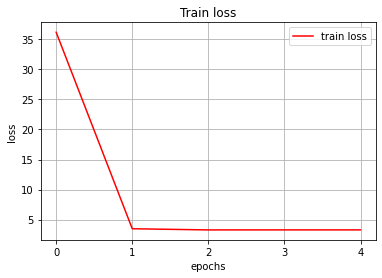

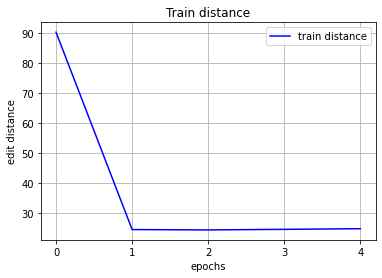

In [23]:
# Train from scratch result
ax1 = plt.figure().gca()
ax1.plot(np.linspace(0,n_epochs-1,n_epochs, dtype=int), Train_loss, 'r')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.grid()
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend(['train loss'])
ax1.set_title('Train loss')

ax2 = plt.figure().gca()
ax2.plot(np.linspace(0,n_epochs-1,n_epochs, dtype=int), Train_dis, 'b')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.grid()
ax2.set_xlabel('epochs')
ax2.set_ylabel('edit distance')
ax2.legend(['train distance'])
ax2.set_title('Train distance')

### 4.2.2 Train Transfer Learning model

In [33]:
# epoch and training info
n_epochs = 5
Train_loss = []
Test_loss = []
Train_dis = []
Test_dis = []


for epoch in tqdm(range(n_epochs), position=0, leave=True):
    # Training and get key results
    for param_group in optimizer.param_groups:
        print('\nlr: ', param_group['lr'])

    start_time = time.time()
    train_loss, train_distance = train(model, knnw_loader, optimizer, criterion)
    end_time = time.time()

    # Record
    Train_loss.append(train_loss)
    Train_dis.append(train_distance)

    # Print to inform
    train_log_text = "\nEpoch: [%d/%d], Training Loss:%2f, Training Distance:%2f, Training Time:%2f" % (epoch, n_epochs-1, train_loss, train_distance, end_time - start_time)
    cprint(train_log_text, color='green', attrs=['bold'])


    # Didn't do CV for now

    # # Evaluation and get key results
    # start_time = time.time()
    # test_loss, test_distance = evaluation(model, dev_loader, optimizer, criterion)
    # end_time = time.time()

    # # Record
    # Test_loss.append(test_loss)
    # Test_dis.append(test_distance)

    # # Print to inform
    # test_log_text = "\nEpoch: [%d/%d], Testing Loss:%2f, Testing Distance:%2f, Testing Time:%2f" % (epoch, n_epochs-1, test_loss, test_distance, end_time - start_time)
    # cprint(test_log_text, color='red', attrs=['bold'])


    # Store model
    if train_distance < best_distance:
        torch.save(model.state_dict(), PATH_save)
        best_distance = train_distance

    # scheduler
    scheduler.step()

  0%|          | 0/21 [00:00<?, ?it/s]


lr:  0.001


100%|██████████| 21/21 [00:51<00:00,  2.47s/it]



Epoch: [0/4], Training Loss:35.812862, Training Distance:67.552764, Training Time:51.837161


  0%|          | 0/21 [00:00<?, ?it/s]


lr:  0.001


100%|██████████| 21/21 [00:49<00:00,  2.34s/it]



Epoch: [1/4], Training Loss:5.015515, Training Distance:24.558507, Training Time:49.068266


  0%|          | 0/21 [00:00<?, ?it/s]


lr:  0.001


100%|██████████| 21/21 [00:48<00:00,  2.31s/it]



Epoch: [2/4], Training Loss:4.557777, Training Distance:24.503948, Training Time:48.444283


  0%|          | 0/21 [00:00<?, ?it/s]


lr:  0.001


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch: [3/4], Training Loss:4.014647, Training Distance:24.508973, Training Time:49.217371

lr:  0.001


100%|██████████| 5/5 [04:11<00:00, 50.35s/it]


Epoch: [4/4], Training Loss:3.744032, Training Distance:24.613783, Training Time:49.603506


Text(0.5, 1.0, 'Train distance (transfer learning)')

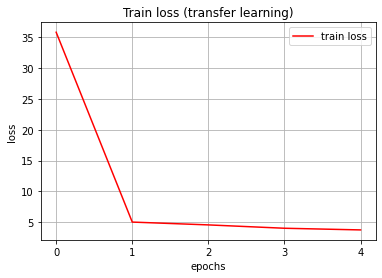

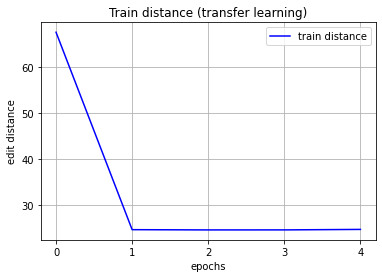

In [35]:
# Transfer Learning train result
ax1 = plt.figure().gca()
ax1.plot(np.linspace(0,n_epochs-1,n_epochs, dtype=int), Train_loss, 'r')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.grid()
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend(['train loss'])
ax1.set_title('Train loss (transfer learning)')

ax2 = plt.figure().gca()
ax2.plot(np.linspace(0,n_epochs-1,n_epochs, dtype=int), Train_dis, 'b')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.grid()
ax2.set_xlabel('epochs')
ax2.set_ylabel('edit distance')
ax2.legend(['train distance'])
ax2.set_title('Train distance (transfer learning)')

### 4.2.3 Manually check some performance

In [36]:
model.eval()
with torch.no_grad():
  x, y, x_lens, y_lens = next(iter(knnw_loader))
  x, y = x.to(device), y.to(device)
  out, out_lens = model(x, x_lens)
  loss = criterion(out, y, out_lens, y_lens)

In [ ]:
print(out)

In [38]:
print(loss)

tensor(3.6416, device='cuda:0')


In [39]:
true_result = ["".join([char_map[w] for w in batch]) for batch in y]
decode_result = ctc_decode(out, out_lens, 20)
s1_all = []
s2_all = []
dist_all = []
for i in range(len(decode_result)):
    s1 = decode_result[i].replace(" ", "")
    s2 = true_result[i].replace(" ", "")
    distance = lev.distance(s1, s2)
    s1_all.append(s1)
    s2_all.append(s2)
    dist_all.append(distance)
print(s1_all)
print(s2_all)
print(dist_all)

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['nothingmoreorless', 'iswearthatillfindyouagainnomatterwhat', 'scalingthewallsoftimeclimber', 'goodmorning', 'whatcouldhavebeenthereason', 'onedaywellreachtoemotionsunexploredunprecedented', 'illdomybest', 'tsukasasaidhewasgonnagoaheadandtakeabath', 'seeyoureyesdrier', 'miyamoridistrict', 'iseeyourenottouchingyourboobiestoday', 'maybeificould', 'isthatyotsuhashesallgrownup', 'gasp', 'noallfuturelives', 'threeyearsago', 'keepyourfullmouthshut', 'msokuderayougettinghungrywecouldgetdinner', 'illseeyouguysatthefestivalbabyewellmeetyaatthestepstoneshrinedontbelatek', 'thewarningsystemyeahthosespeakersalloverthetown', 'overdied', 'waitlongyeahaahnouh', 'hereshegoes', 'justgivemeonemorechance', 'itstheperfectplan', 'ihavetogosomewheregobac

## 5.2 Test

### 5.2.1 Load Test Data

In [ ]:
class MyTestDataset(data.Dataset):
  def __init__(self, X):
    self.X = X
    self.length = len(self.X)

  def __len__(self):
    return self.length

  def __getitem__(self, index):
    res_X = torch.from_numpy(self.X[index]).float()
    return res_X

In [ ]:
def pad_collate_test(batch):
    xx = [x for x in batch]
    x_lens = torch.LongTensor([len(x) for x in xx])

    xx_pad = pad_sequence(xx, batch_first=True)
    return xx_pad, x_lens

In [ ]:
# Test data set
test_dataset = MyTestDataset(test_data)
test_loader = data.DataLoader(
          dataset=test_dataset,           
          batch_size=64,
          num_workers=4,
          collate_fn=pad_collate_test,
          shuffle=False,
          pin_memory=True)

### 5.2.2 Make Predictions

In [ ]:
# Predict
predictions = []

model.eval()
with torch.no_grad():
  for id, (x, x_lens) in enumerate(tqdm(test_loader, position=0, leave=True)):
    # To GPU
    x = x.to(device)

    # Foward
    out, out_lens = model(x, x_lens)

    # result
    decode_result = ctc_decode(out, x_lens, 50)

    predictions.append(decode_result)

In [ ]:
# Flatten predictions
flat_predictions = [item for sublist in predictions for item in sublist]